In this notebook we will compare the usual ResNet and ResNet with squeeze and excitation block.	At the beginning figure out what this block is.

### Squeeze and excitation [block](https://arxiv.org/abs/1709.01507).

CNNs use their convolutional filters to extract hierarchal information from the image, but even last layers have smaller receptive field than input image, therefore each pixel will not take into account all channel and spatial information.

All of this works by fusing the spatial and channel information of an image. The different filters will first find spatial features in each input channel before adding the information across all available output channels.
<img src='pictures/se_block.png'>
____________
## __Squeeze block__ 
First, they get a global understanding of each channel by squeezing the feature maps to a single numeric value. This results in a vector of size n, where n is equal to the number of convolutional channels. 
<img src='pictures/squeeze.png'>
## __Excitation block__
Afterwards, it is fed through a two-layer neural network, which outputs a vector of the same size. These n values can now be used as weights on the original features maps, scaling each channel based on its importance.
<img src='pictures/exictation.png'>

For more information, you can read [this](https://towardsdatascience.com/squeeze-and-excitation-networks-9ef5e71eacd7).

In [1]:
import os
import sys

import blosc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pandas import ewma
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline

sys.path.append('../..')
sys.path.append('..')

import utils
from dataset import B,V,F
from dataset.dataset.opensets import MNIST
from dataset.dataset.models.tf import ResNet

In [2]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

As always, first of all, we create batch class - MNIST.

In [3]:
dset = MNIST()

Extracting ExtractingExtractingExtracting/tmp/train-labels-idx1-ubyte.gz   
/tmp/t10k-images-idx3-ubyte.gz/tmp/train-images-idx3-ubyte.gz/tmp/t10k-labels-idx1-ubyte.gz




Then create a config for the input and output tensors.

In [4]:
placeholders_config = {
                       'images': {'shape': (28, 28, 1)},
                
                       'labels': {'classes': (10),
                                  'transform': 'ohe',
                                  'dtype': 'int32',
                                  'name': 'targets'}
                       }

We will use standard resnet from the models of the dataset. Available options can be found [here](https://analysiscenter.github.io/dataset/api/dataset.models.tf.resnet.html).

For comparison, we will create two identical ResNet models. In one will be the usual blocks, in the other SE_blocks. SE_block is added to the model by key __'body/block/se_block'__ which you can see below.

In [5]:
ResNet_config = {'inputs': placeholders_config,
                 'input_block/inputs': 'images',
                 'body/num_blocks': [1, 1, 1, 1],
                 'body/filters': [64, 128, 256, 512],
                 'loss': 'softmax_cross_entropy',
                 'optimizer': 'Adam',
                 'body/block/bottleneck': 1} 
Bottlenet_config = {**ResNet_config, 'body/block/se_block': 1}

And create placeholders for our models.

In [6]:
placehold_dict = {'images': B('images'),
                  'labels': B('labels')}

Now we will create the pipelines with the given configurations to simple ResNet model.

In [7]:
res_train_ppl = (dset.train
           .p
           .init_model('dynamic',
                      ResNet,
                      'resnet',
                      config=ResNet_config)
           .train_model('resnet',
                        feed_dict=placehold_dict))
res_test_ppl = (dset.test
           .p
           .init_variable('resloss', init_on_each_run=list)
           .import_model('resnet', res_train_ppl)
           .predict_model('resnet',
                        fetches='loss',
                        feed_dict=placehold_dict,
                        save_to=V('resloss'), mode='a'))

And to ResNet model with SE blocks.

In [8]:
se_train_ppl = (dset.train
           .p
           .init_model('dynamic',
                      ResNet,
                      'se_block',
                      config=Bottlenet_config)
           .train_model('se_block',
                        feed_dict=placehold_dict))
se_test_ppl = (dset.test
           .p
           .init_variable('seloss', init_on_each_run=list)
           .import_model('se_block', se_train_ppl)
           .predict_model('se_block',
                        fetches='loss',
                        feed_dict=placehold_dict,
                        save_to=V('seloss'), mode='a'))

After that, we will train our models.

In [9]:
for i in tqn(range(500)):
    res_train_ppl.next_batch(300, n_epochs=None, shuffle=2)
    res_test_ppl.next_batch(300, n_epochs=None, shuffle=2)
    se_train_ppl.next_batch(300, n_epochs=None, shuffle=2)
    se_test_ppl.next_batch(300, n_epochs=None, shuffle=2)

Let's show the entire learning process

../utils.py:37: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../utils.py:38: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


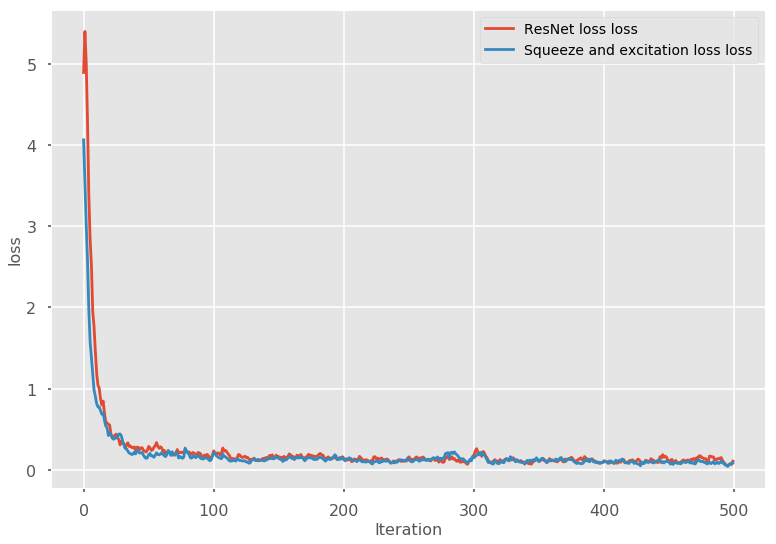

In [10]:
ResNet_loss = res_test_ppl.get_variable('resloss')
SE_loss = se_test_ppl.get_variable('seloss')
utils.draw(ResNet_loss, 'ResNet loss', SE_loss, 'Squeeze and excitation loss')

Not difficult to see, that squeeze and excitation block give better equality than simple resnet. And se_resnet have approximately the same number of parameters SE_resnet(23994378) and simple resnet(23495690).

While SE blocks have been empirically shown to improve network performance, let's understand how the self-gating excitation mechanism operates in practice. To provide a clearer picture of the behavior of SE blocks, in this section we study example activations from our SE-ResNet and examine their distribution with respect to different classes at different blocks.

In [11]:
def get_maps(graph, ppl, sess):
    operations = graph.get_operations()
    head_operations = [oper for oper in operations if 'head' in oper.name]
    oper_name = head_operations[1].name + ':0'

    next_batch = ppl.next_batch()
    maps = sess.run(oper_name, feed_dict={'ResNet/inputs/images:0': next_batch.images, 
                                          'ResNet/inputs/labels:0': next_batch.labels,
                                          'ResNet/globals/is_training:0': False})
    return maps, next_batch.labels

Loading our maps and answers

In [12]:
res_sess = res_test_ppl.get_model_by_name("resnet").session
res_graph = res_sess.graph

se_sess = se_test_ppl.get_model_by_name('se_block').session
se_graph = se_sess.graph

res_maps, res_answers = get_maps(res_graph, res_test_ppl, res_sess)
se_maps, se_answers = get_maps(se_graph, se_test_ppl, se_sess)

Draw a graph of the distribution of card activations after GAP for individual classes. Each line is distribution of one class.

../utils.py:214: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  plt.plot(ewma(filters[i], span=350, adjust=False), color=col[i], label=str(i))


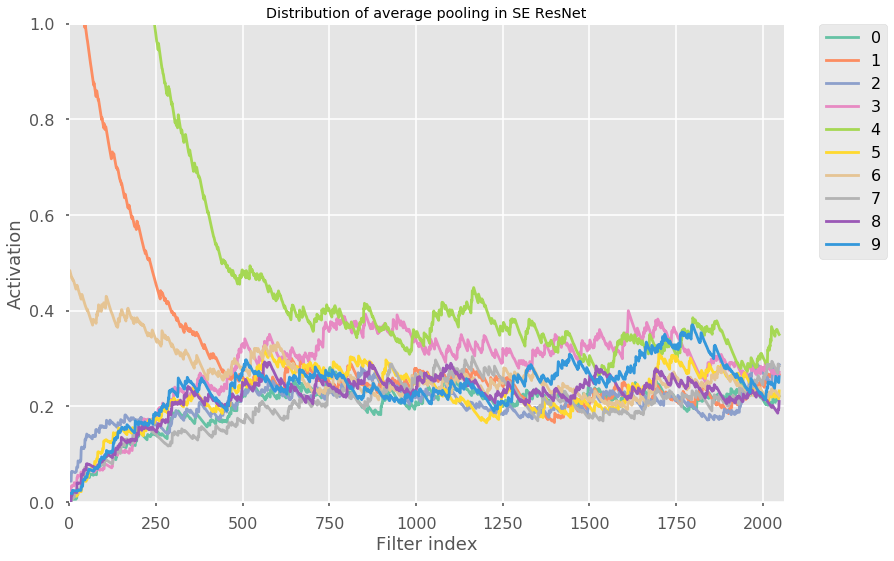

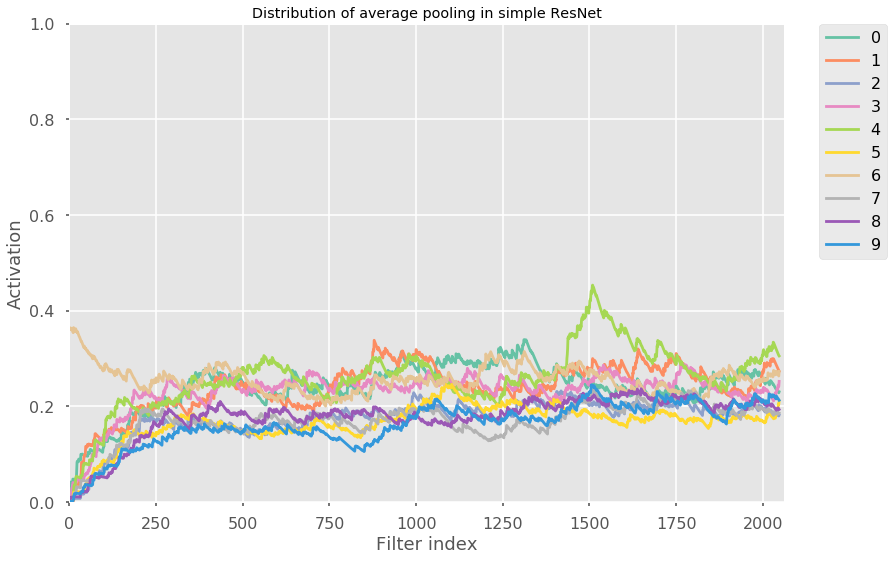

In [13]:
utils.draw_avgpooling(res_maps, res_answers)
utils.draw_avgpooling(se_maps, se_answers, False)

### Conclutions:
* Squeeze and excitation block give better equality than simple resnet with the same number of parameters.
* that distribution of se_resnet maps bigger, than simple resnet. In this case distribution is distance between lines and the more, the merrier, the network make a choice.

### And what next?
* You can create ResNet model with SE_block and and test it yourself.
* Read another researches:
    * [Stochastic_ResNet]()
    * [zero_weights]()
    * [FreezeOut]()